In [90]:
# 모듈로딩
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

import torch
import torch.nn as nn            # LinearRegression기능의 클래스
import torch.nn.functional as F  # 손실함수
import torch.optim as optim      # 경사하강법 기반의 최적화 관련 모듈

In [91]:
# 데이터 준비
fashion_db = 'fashion-mnist'
fashion_data = fetch_openml(name = fashion_db, parser = 'auto')  # as_frame = False로 설정하면 넘파이로 데이터 받는다.

In [92]:
# 데이터 확인
feature = fashion_data['data']
target = fashion_data['target']

In [93]:
# 피처와 타겟 개수 확인
print(f'FEATURE => {feature.shape}, {feature.ndim}D')
print(f'TARGET => {target.shape}, {target.ndim}D')

FEATURE => (70000, 784), 2D
TARGET => (70000,), 1D


In [94]:
# 분류 확인
print(f"FEATURE NAME => {fashion_data['feature_names']}\n")
print(f"TARGET NAME => {fashion_data['target_names']}\n")
print(f"CATEGORIES NAME => {fashion_data['categories']}\n")  # 데이터를 넘파이로 받으면 값 반환
print(f"CATEGORIES => {target.unique()}")

FEATURE NAME => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'p

[2] 데이터 가공 및 전처리 <hr>
- 결측치/중복/이상치 => 없음
- 다중분류 => 2진분류 변환 : target 변환
- 표준화 => 이미지 동일 크기 및 색상 : 동일 크기와 채널
- 정규화 => 피처 정규화 / 타겟 정규화 

In [95]:
# [2-1] 다중분류 ===> 2진분류 => target 변환
target = target == '0'
target.unique()

array([False,  True])

In [96]:
# [2-2] 정규화 ===> 피처 : 784개 색상값 즉, 0 ~ 255 범위 값
norm_feature = feature / 255.

In [97]:
### ===> [2-2] 정규화 ===> 타겟 : One-Hot 인코딩으로 변환
pd.get_dummies(target)

,False,True
0,True,False
1,False,True
2,False,True
3,True,False
4,False,True
...,...,...
69995,True,False
69996,True,False
69997,True,False
69998,True,False


In [98]:
from sklearn.preprocessing import OneHotEncoder

targetDF = target.to_frame()
ohe = OneHotEncoder(sparse_output = False)  # sparse_output = False => ndarray로 반환
ohe.fit(targetDF)  # 2차원으로 바꿔서 넣는다.
ohe.categories_

[array([False,  True])]

In [99]:
norm_target = ohe.transform(targetDF)
norm_target.shape, norm_target.ndim

((70000, 2), 2)

[3] 학습 준비 <hr>
- 데이터 텐서화
- 데이터셋 준비 : 훈련용, 테스트용
- 학습 방법 : 지도학습 - 이진분류 => Linear 클래스 + sigmoid 함수
- 최적화 방법: 경사하강법
- 손실 함수 : 이진 분류 손실 계산 함수 => binary_cross_entropy 

In [100]:
# 데이터셋 준비 : 60000개 훈련, 10000개 테스트
limit = 60000
train = norm_feature.iloc[:limit]
test = norm_feature.iloc[limit:]

train_y = norm_target[:limit]
test_y = norm_target[limit:]

In [101]:
print(f'train => {train.shape}, {train.ndim}D,  {train_y.shape}, {train_y.ndim}D')
print(f'test => {test.shape}, {test.ndim}D,  {test_y.shape}, {test_y.ndim}D')

train => (60000, 784), 2D,  (60000, 2), 2D
test => (10000, 784), 2D,  (10000, 2), 2D


In [102]:
# 텐서로 변환
X_train = torch.FloatTensor(train.values) 
X_test = torch.FloatTensor(test.values)

y_train = torch.FloatTensor(train_y)
y_test = torch.FloatTensor(test_y)

In [103]:
print(f'train => {X_train.shape}, {X_train.ndim}D,  {y_train.shape}, {y_train.ndim}D')
print(f'test => {X_test.shape}, {X_test.ndim}D,  {y_test.shape}, {y_test.ndim}D')

train => torch.Size([60000, 784]), 2D,  torch.Size([60000, 2]), 2D
test => torch.Size([10000, 784]), 2D,  torch.Size([10000, 2]), 2D


In [104]:
# 학습 인스턴스 생성
in_, out_ = X_train.shape[1], y_train.shape[1]
model = nn.Linear(in_, out_)
model

Linear(in_features=784, out_features=2, bias=True)

In [105]:
# 최적화 인스턴스 생성 => 모델에서 사용하는 W, b 변수들 전달
optimizer = optim.Adam(model.parameters())

In [106]:
# 학습 횟수 => 샘플 처음부터 끝까지 읽는 것을 기준으로 횟수 지정
EPOCHS = 150

[4] 학습 <hr>
- 반복 횟수만큼 학습 진행

In [107]:
loss_accuaray = [[], []]
for ep in range(EPOCHS):
    # 학습
    pre_y = model(X_train)
    print(f'예측값 : {pre_y}')
    # 분류값 변환
    pre_y2 = F.sigmoid(pre_y)
    # print(f'분류값 : {pre_y2}')

    # 오차 즉 손실 계산
    loss = F.binary_cross_entropy(pre_y2, y_train)
    loss_accuaray[0].append(round(loss.item(), 2))
    print(f'[{ep}] Loss => {round(loss.item(), 2)}')

    # W, b 업데이트
    optimizer.zero_grad()
    loss.backward()   # 손실함수 계산값으로 미분 진행하여 새로운 W, b 계산
    optimizer.step()  # 새로운 값으로 W, b 업데이트

    # 정확도 계산 => 예측값을 0과 1로 변환 => 정답과 비교
    train_accuracy = (y_train.argmax(dim = 1) == (pre_y2.argmax(dim = 1))).sum() / y_train.shape[0]
    loss_accuaray[1].append(round(train_accuracy.item(), 2))
    print(f'훈련 정확도 => {round(train_accuracy.item(), 2)}')

예측값 : tensor([[-0.4635,  0.2494],
        [-0.6951,  0.0235],
        [-0.2009,  0.0146],
        ...,
        [-0.5746,  0.0260],
        [-0.1961,  0.1279],
        [-0.0009,  0.2349]], grad_fn=<AddmmBackward0>)
[0] Loss => 0.8
훈련 정확도 => 0.14
예측값 : tensor([[-0.1635, -0.0506],
        [-0.3624, -0.3092],
        [-0.0875, -0.0988],
        ...,
        [-0.3283, -0.2203],
        [-0.0637, -0.0045],
        [ 0.0655,  0.1685]], grad_fn=<AddmmBackward0>)
[1] Loss => 0.7
훈련 정확도 => 0.48
예측값 : tensor([[ 0.1349, -0.3484],
        [-0.0320, -0.6370],
        [ 0.0253, -0.2111],
        ...,
        [-0.0835, -0.4642],
        [ 0.0678, -0.1346],
        [ 0.1316,  0.1025]], grad_fn=<AddmmBackward0>)
[2] Loss => 0.62
훈련 정확도 => 0.86
예측값 : tensor([[ 0.4300, -0.6418],
        [ 0.2933, -0.9544],
        [ 0.1366, -0.3213],
        ...,
        [ 0.1582, -0.7036],
        [ 0.1973, -0.2606],
        [ 0.1970,  0.0373]], grad_fn=<AddmmBackward0>)
[3] Loss => 0.56
훈련 정확도 => 0.89
예측값 : tensor([[ 0.

예측값 : tensor([[ 3.6830, -3.6968],
        [ 2.9022, -2.8365],
        [ 1.2001, -1.1940],
        ...,
        [ 2.4650, -2.5981],
        [ 1.2828, -1.0893],
        [ 0.9686, -0.7205]], grad_fn=<AddmmBackward0>)
[20] Loss => 0.35
훈련 정확도 => 0.9
예측값 : tensor([[ 3.7596, -3.7598],
        [ 2.8825, -2.7716],
        [ 1.2079, -1.1865],
        ...,
        [ 2.4823, -2.5834],
        [ 1.2810, -1.0717],
        [ 0.9918, -0.7434]], grad_fn=<AddmmBackward0>)
[21] Loss => 0.35
훈련 정확도 => 0.9
예측값 : tensor([[ 3.8265, -3.8138],
        [ 2.8498, -2.6952],
        [ 1.2110, -1.1748],
        ...,
        [ 2.4898, -2.5598],
        [ 1.2741, -1.0497],
        [ 1.0130, -0.7645]], grad_fn=<AddmmBackward0>)
[22] Loss => 0.35
훈련 정확도 => 0.9
예측값 : tensor([[ 3.8846, -3.8597],
        [ 2.8052, -2.6086],
        [ 1.2101, -1.1593],
        ...,
        [ 2.4883, -2.5282],
        [ 1.2627, -1.0237],
        [ 1.0325, -0.7841]], grad_fn=<AddmmBackward0>)
[23] Loss => 0.34
훈련 정확도 => 0.9
예측값 : tensor([[ 

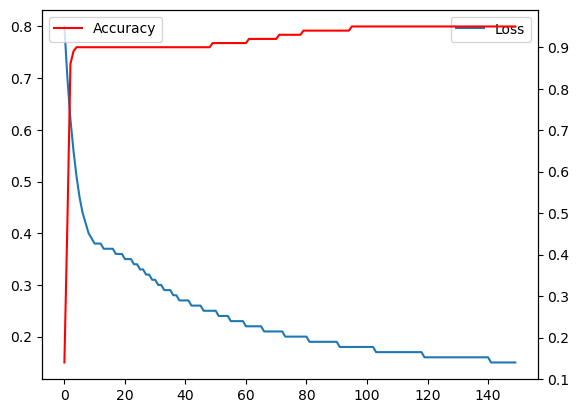

In [108]:
# 손실과 정확도 시각화
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(loss_accuaray[0], label = 'Loss')
plt.legend()
ax2 = ax1.twinx()
ax2.plot(loss_accuaray[1], label = 'Accuracy', color = 'red')
plt.legend()
plt.xlabel('Epochs')
plt.show()